<a href="https://colab.research.google.com/github/Trip1ewhy/Duke_xAI_Wayne/blob/main/Assignment_02_Wayne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #02
### Adversarial Attacks (Adversarial Patches)
Instructions
Create your own adversarial patch. We will use the Torchvision ResNet34 model trained on a small version of ImageNet to test your patch. You will need to use a class from the imagenet_classes.txt file (see GitHub) for your patch.



torchvision.models.resnet34(weights='IMAGENET1K_V1')


In addition to creating your adversarial patch, you must apply some creative component to your patch. Here are some ideas, but this is open-ended:

“Disguise” the patch in a sticker, like they did in Brown, et.al.
“Disguise” your patch in something else (ie clothing, jewelry, accessories, household items)
Combine two patches into one and test the results (what happens?)
Send a secret message using a series of patches
### Wayne Yang

#### Include the button below. Change the link to the location in your github repository:
#### https://github.com/Trip1ewhy/Duke_xAI_Wayne/blob/51290060b5f29826b761f848f38d9514156082ce/Assignment%20%2302.ipynb


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/Trip1ewhy/Duke_xAI_Wayne/blob/51290060b5f29826b761f848f38d9514156082ce/Assignment%20%2302.ipynb)

In [1]:
!rm -r ./sample_data

In [2]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data


# Clone GitHub files to colab workspace
repo_name = "Duke_xAI_Wayne" # Change to your repo name
git_path = 'https://github.com/Trip1ewhy/Duke_xAI_Wayne.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'Assignment #02_Wayne'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

Cloning into 'Duke_xAI_Wayne'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 55 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (55/55), 24.41 MiB | 6.95 MiB/s, done.
Resolving deltas: 100% (3/3), done.
[Errno 2] No such file or directory: 'Duke_xAI_Wayne/Assignment #02_Wayne'
/content
Duke_xAI_Wayne/


In [3]:
!pip install torch torchvision adversarial-robustness-toolbox
#!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.5 MB/s eta 0:00:00


In [4]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import AdversarialPatch
from art.estimators.classification import PyTorchClassifier
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import io



In [5]:
# Load the pre-trained ResNet34 model with ImageNet weights
evalmodel = models.resnet34(weights='IMAGENET1K_V1')

# Set the model to evaluation mode since we won't be training it
evalmodel.eval()


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 156MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
df = pd.read_parquet("/content/Duke_xAI_Wayne/Assignment #02/tench.parquet")

# 查看数据
print(df.head())


                                               image  label
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0


In [7]:
# 假设标签列名为 'label'，提取标签为 0 的数据
df_label_0 = df[df['label'] == 0]

# check first several rows
print(df_label_0.head())
print(len(df_label_0))
#df_label_0.to_parquet("/content/Duke_xAI_Wayne/Assignment #02/filename.parquet")

                                               image  label
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
1300


In [8]:
# Load ImageNet classes from the file
with open('/content/Duke_xAI_Wayne/Assignment #02/imagenet_classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]

# Select a target class, which we want the model to misunderstand
target_class = "tench"
target_class_index = classes.index(target_class)

# Print the target class and its index
print(f"Target class: {target_class}, Index: {target_class_index}")


Target class: tench, Index: 0


In [9]:
#verify index 0 is tench:
print(classes[0])

tench


## Use ART to generate Adversarial Patches
references: Duke-AI-XAI/adversarial-ai-example-notebooks
/in_class_adversarial_activity.ipynb



Prepare the dataset

In [13]:
# 自定义数据集类，用于将筛选后的 pandas 数据集转换为 PyTorch 可处理的数据集
class ParquetDataset(Dataset):
    def __init__(self, data_frame, transform=None):
        self.data = data_frame  # 直接使用传入的 DataFrame
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 获取图像的字节流
        image_bytes = self.data.iloc[idx]['image']['bytes']
        # 从字节流中读取图像
        image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
        label = self.data.iloc[idx]['label']  # 获取标签

        # 如果有图像转换操作，则应用
        if self.transform:
            image = self.transform(image)

        return image, label

# 定义转换操作
transform = transforms.Compose([
    transforms.Resize((500, 500)),  # 调整图像大小
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 归一化
])

# 加载筛选后的 DataFrame 数据集
dataset = ParquetDataset(data_frame=df_label_0, transform=transform)

# 使用 DataLoader 加载数据
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

# check data
images, labels = next(iter(dataloader))
#print(images, labels)



In [14]:
images[0]
print("Tensor shape:", images[0].shape)

Tensor shape: torch.Size([3, 500, 500])


In [15]:
# 加载预训练模型 (以 ResNet 为例)
model = models.resnet34(weights='IMAGENET1K_V1')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
def generate_adversarial_patch(model, dataloader, patch_shape=(3, 500, 500), target_label=0, learning_rate=0.5, max_iter=100, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # 定义 PyTorch 分类器
    classifier = PyTorchClassifier(
        model=model,
        loss=nn.CrossEntropyLoss(),
        input_shape=(3, 500, 500),
        nb_classes=1000,
        clip_values=(0, 1),
        device_type=device.type
    )

    # 定义 Adversarial Patch 攻击方法
    attack = AdversarialPatch(
        classifier=classifier,
        patch_shape=patch_shape,
        learning_rate=learning_rate,
        max_iter=max_iter
    )

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # 迭代 dataloader 中的所有批次
        images, labels = next(iter(dataloader))

        # 生成目标类别列表, 每个图像都指向 target_label
        target_labels = torch.full_like(labels, target_label).to(device)
        print(target_labels)
        # 生成针对目标类别的对抗性补丁
        adversarial_patch = attack.generate(x=images.cpu().numpy(), y=target_labels.cpu().numpy())

        # 检查补丁是否是 tuple 类型并取第一个元素
        if isinstance(adversarial_patch, tuple):
            adversarial_patch = adversarial_patch[0]

        # 检查补丁的形状
        print("Adversarial patch shape:", adversarial_patch.shape)

        # 将补丁转换为 PyTorch 张量并移动到设备
        adversarial_patch = torch.tensor(adversarial_patch).to(device)
        adversarial_patch = adversarial_patch.cpu().numpy()  # 将张量转换为 NumPy 数组

    return adversarial_patch

In [25]:
# generate A.patch
adversarial_patch = generate_adversarial_patch(model, dataloader)

Epoch 1/10
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')


Adversarial Patch PyTorch:   0%|          | 0/100 [00:00<?, ?it/s]

Adversarial patch shape: (3, 500, 500)
Epoch 2/10
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')


Adversarial Patch PyTorch:   0%|          | 0/100 [00:00<?, ?it/s]

Adversarial patch shape: (3, 500, 500)
Epoch 3/10
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')


Adversarial Patch PyTorch:   0%|          | 0/100 [00:00<?, ?it/s]

Adversarial patch shape: (3, 500, 500)
Epoch 4/10
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')


Adversarial Patch PyTorch:   0%|          | 0/100 [00:00<?, ?it/s]

Adversarial patch shape: (3, 500, 500)
Epoch 5/10
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')


Adversarial Patch PyTorch:   0%|          | 0/100 [00:00<?, ?it/s]

Adversarial patch shape: (3, 500, 500)
Epoch 6/10
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')


Adversarial Patch PyTorch:   0%|          | 0/100 [00:00<?, ?it/s]

Adversarial patch shape: (3, 500, 500)
Epoch 7/10
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')


Adversarial Patch PyTorch:   0%|          | 0/100 [00:00<?, ?it/s]

Adversarial patch shape: (3, 500, 500)
Epoch 8/10
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')


Adversarial Patch PyTorch:   0%|          | 0/100 [00:00<?, ?it/s]

Adversarial patch shape: (3, 500, 500)
Epoch 9/10
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')


Adversarial Patch PyTorch:   0%|          | 0/100 [00:00<?, ?it/s]

Adversarial patch shape: (3, 500, 500)
Epoch 10/10
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')


Adversarial Patch PyTorch:   0%|          | 0/100 [00:00<?, ?it/s]

Adversarial patch shape: (3, 500, 500)


In [26]:
#adversarial_patch[0].ndim

In [27]:
type(adversarial_patch)

numpy.ndarray

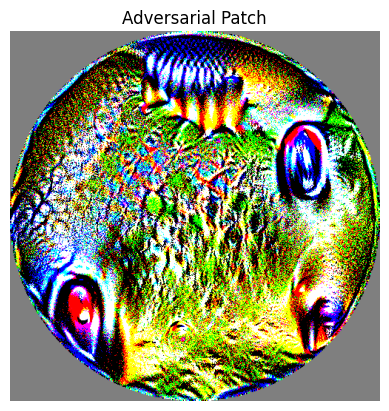

In [28]:
patch_data = np.clip(adversarial_patch, 0, 1)  # limit the value to [0,1]

# check the shape of the patch
#print("Patch data shape before transpose:", patch_data.shape)

# 如果 patch_data 是 (channels, height, width)，需要转换为 (height, width, channels)
if patch_data.shape[0] == 3:
    patch_data = np.transpose(patch_data, (1, 2, 0))  # 转换为 (height, width, channels)

# 再次检查形状
#print("Patch data shape after transpose:", patch_data.shape)

# 将 patch_data 从浮点型转换为整数类型，保持色彩精度
patch_data_uint8 = (patch_data * 255).astype(np.uint8)

# 创建 RGB 图像
image_patch = Image.fromarray(patch_data_uint8, 'RGB')

# 显示图像
plt.imshow(image_patch)
plt.axis('off')  # 隐藏坐标轴
plt.title("Adversarial Patch")
plt.show()

# 保存图像为高质量的 jpg
image_patch = image_patch.resize((200, 200))
image_patch.save("/content/Duke_xAI_Wayne/Assignment #02/adversarial_patch.jpg", quality=95)

In [29]:
image_patch.size

(200, 200)

Test patch

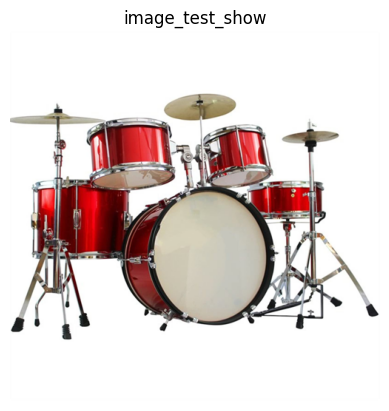

Top 10 predicted classes and probabilities for the test image:
Class 541 with probability 0.7134803533554077
Class 542 with probability 0.13796062767505646
Class 822 with probability 0.03781585022807121
Class 494 with probability 0.007268624380230904
Class 642 with probability 0.004717451520264149
Class 577 with probability 0.0043734339997172356
Class 819 with probability 0.0039039961993694305
Class 641 with probability 0.002456681802868843
Class 650 with probability 0.0020801653154194355
Class 420 with probability 0.0018352194456383586


In [32]:
image_path_test = '/content/Duke_xAI_Wayne/Assignment #02/Drum_test1.jpg'  # 替换为你自己的图片路径
#image_test = Image.open(image_path_test)
#image_test = transform(image_test).squeeze(0)  # 添加 batch 维度
image_test = Image.open(image_path_test)
image_test = image_test.resize((500, 500))
# Show the image directly using plt.imshow
plt.imshow(image_test)
plt.title("image_test_show")
plt.axis('off')
plt.show()
transform = transforms.Compose([
    transforms.Resize((500, 500)),  # Adjust size as required by your model
    transforms.ToTensor(),  # Convert PIL image to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Use ImageNet normalization if using a pre-trained model
])

# Apply the transformation to the image
image_test_change = transform(image_test).unsqueeze(0)  # Add batch dimension

# Pass the image through the model and compute the output
with torch.no_grad():
    outputs = evalmodel(image_test_change)  # Get logits (unnormalized scores)

# Convert logits to probabilities using softmax
probabilities = F.softmax(outputs, dim=1)

# Get the top 10 predicted classes and their probabilities
topk = 10  # Top 10 predicted classes
topk_probabilities, topk_indices = probabilities.topk(topk, dim=1, largest=True, sorted=True)

# Print the top 10 classes and their probabilities
print(f"Top {topk} predicted classes and probabilities for the test image:")
for i in range(topk):
    print(f"Class {topk_indices[0][i].item()} with probability {topk_probabilities[0][i].item()}")

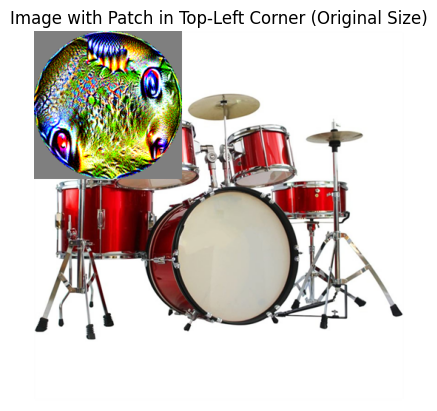

Top 10 predicted classes and probabilities for the test image with patch:
Class 541 with probability 0.5940089225769043
Class 542 with probability 0.13892117142677307
Class 822 with probability 0.04425091668963432
Class 577 with probability 0.013048265129327774
Class 494 with probability 0.00968853011727333
Class 819 with probability 0.008721807040274143
Class 641 with probability 0.007335079368203878
Class 632 with probability 0.005130631383508444
Class 642 with probability 0.0049265967682003975
Class 650 with probability 0.004119369201362133


In [33]:
# 假设 image_patch 是你的对抗性补丁，image_test 是你的测试图像
#image_path_test = '/content/Duke_xAI_Wayne/Assignment #02/Drum_test2.jpg'  # 替换为你自己的图片路径
#image_test = Image.open(image_path_test)

# 假设 image_patch 是你生成的补丁，加载补丁图像（之前已经创建了 image_patch）
# 你可以直接使用已经生成的 patch 数据
#image_patch = Image.open("/path/to/your/adversarial_patch.jpg")  # 替换为实际路径

# 获取图像的原始大小
#test_image_size = image_test.size  # (width, height)
#patch_size = image_patch.size  # 对抗性补丁的大小

# 将 patch 粘贴到 image_test 的左上角 (不改变原始大小)
image_test = image_test.convert('RGB')
image_patch = image_patch.convert('RGB')
image_test.paste(image_patch, (0, 0))

# 展示叠加后的图像
plt.imshow(image_test)
plt.title("Image with Patch in Top-Left Corner (Original Size)")
plt.axis('off')
plt.show()

# 使用与模型相同的 transform 处理粘贴后的图像，但不调整大小
transform = transforms.Compose([
    transforms.ToTensor(),  # 转换为 PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 使用 ImageNet 标准化
])

# 将图像转换为 Tensor，并添加 batch 维度
image_test_change = transform(image_test).unsqueeze(0)

# 将图像输入到模型中进行推理
with torch.no_grad():
    outputs = evalmodel(image_test_change)  # 获取模型的输出 (logits)

# 使用 softmax 计算概率分布
probabilities = F.softmax(outputs, dim=1)

# 获取前10个预测类别及其概率
topk = 10  # 前10个预测类别
topk_probabilities, topk_indices = probabilities.topk(topk, dim=1, largest=True, sorted=True)

# 打印前10个预测类别及其概率
print(f"Top {topk} predicted classes and probabilities for the test image with patch:")
for i in range(topk):
    print(f"Class {topk_indices[0][i].item()} with probability {topk_probabilities[0][i].item()}")
